# Практическая работа 8. Анализ метода загрузки данных

In [1]:
!pip install psycopg2-binary pandas sqlalchemy matplotlib numpy

Defaulting to user installation because normal site-packages is not writeable


In [109]:
import psycopg2
from psycopg2 import Error
from psycopg2 import extras # For execute_values
import pandas as pd
from sqlalchemy import create_engine
import io # For StringIO
import time
import matplotlib.pyplot as plt
import numpy as np
import os # To check file existence


In [3]:
small_csv_path = r'"C:\Users\User\Downloads\upload_test_data.csv"'

In [4]:
big_csv_path = r'"C:\Users\User\Downloads\upload_test_data_big.csv"'

### Установка и импорт необходимых библиотек.

In [ ]:
print("Libraries installed and imported successfully.")

# Database connection details (replace with your actual credentials if different)
DB_USER = "postgres"
DB_PASSWORD = "235532"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "lect_08_bda_big_data"

# CSV File Paths (Ensure these files are uploaded to your Colab environment)
small_csv_path = 'upload_test_data.csv'
big_csv_path = 'upload_test_data_big.csv' # Corrected filename

# Table name in PostgreSQL
table_name = 'sales_data'

Libraries installed and imported successfully.


### Проверка соединения с базой данных PostgreSQL.

In [ ]:
connection = None
cursor = None
engine = None # For pandas.to_sql

try:
    # Establish connection using psycopg2
    print("Connecting to PostgreSQL database using psycopg2...")
    connection = psycopg2.connect(user=DB_USER,
                                  password=DB_PASSWORD,
                                  host=DB_HOST,
                                  port=DB_PORT,
                                  database=DB_NAME)
    connection.autocommit = False # Important for COPY and batch inserts within transactions
    cursor = connection.cursor()

    print("PostgreSQL server information:")
    print(connection.get_dsn_parameters(), "\n")
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print(f"Successfully connected to: {record[0]}\n")

    # Create SQLAlchemy engine for pandas
    print("Creating SQLAlchemy engine...")
    engine_url = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    engine = create_engine(engine_url)
    print("SQLAlchemy engine created successfully.")


except (Exception, Error) as error:
    print(f"Error while connecting to PostgreSQL: {error}")
    # Ensure resources are closed even if connection fails partially
    if cursor:
        cursor.close()
    if connection:
        connection.close()
    if engine:
        engine.dispose() # Close SQLAlchemy engine pool
    connection, cursor, engine = None, None, None # Reset variables

# We keep the connection open for the rest of the script.
# It will be closed in the final step.

Connecting to PostgreSQL database using psycopg2...
PostgreSQL server information:
{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'lect_08_bda_big_data', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'} 

Successfully connected to: PostgreSQL 17.3 on x86_64-windows, compiled by msvc-19.42.34436, 64-bit

Creating SQLAlchemy engine...
SQLAlchemy engine created successfully.


### Анализ структуры CSV файлов

Загрузим небольшой фрагмент данных из каждого файла, чтобы увидеть структуру.

In [ ]:
if connection: # Proceed only if connection is established
    try:
        print(f"--- Analyzing {small_csv_path} ---")
        if os.path.exists(small_csv_path):
            df_small_sample = pd.read_csv(small_csv_path, nrows=5)
            print("First 5 rows:")
            print(df_small_sample)
            print("\nData Types (inferred by Pandas):")
            print(df_small_sample.info())
        else:
            print(f"ERROR: File not found: {small_csv_path}. Please upload it.")

        print(f"\n--- Analyzing {big_csv_path} ---")
        if os.path.exists(big_csv_path):
            df_big_sample = pd.read_csv(big_csv_path, nrows=5)
            print("First 5 rows:")
            print(df_big_sample)
            print("\nData Types (inferred by Pandas):")
            print(df_big_sample.info())
        else:
             print(f"ERROR: File not found: {big_csv_path}. Please upload it.")

    except Exception as e:
        print(f"An error occurred during file analysis: {e}")
else:
    print("Database connection not established. Skipping data analysis.")

--- Analyzing upload_test_data.csv ---
First 5 rows:
   id  quantity  cost  total_revenue
0   1        33  0.50          16.50
1   2        16  6.92         110.72
2   3        17  7.77         132.09
3   4        17  7.73         131.41
4   5         9  3.07          27.63

Data Types (inferred by Pandas):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5 non-null      int64  
 1   quantity       5 non-null      int64  
 2   cost           5 non-null      float64
 3   total_revenue  5 non-null      float64
dtypes: float64(2), int64(2)
memory usage: 292.0 bytes
None

--- Analyzing upload_test_data_big.csv ---
First 5 rows:
   id  quantity  cost  total_revenue
0   1        33  0.50          16.50
1   2        16  6.92         110.72
2   3        17  7.77         132.09
3   4        17  7.73         131.41
4   5         9  3.07   

### Создание таблицы в PostgreSQL перед загрузкой данных.

In [ ]:
if connection and cursor:
    try:
        # Drop the table if it exists (for repeatable testing)
        print(f"Dropping table '{table_name}' if it exists...")
        cursor.execute(f"DROP TABLE IF EXISTS {table_name};")
        connection.commit() # Commit the drop
        print(f"Table '{table_name}' dropped successfully or did not exist.")

        # Create the table with the defined schema
        create_table_query = f"""
        CREATE TABLE {table_name} (
            id INTEGER PRIMARY KEY,
            quantity INTEGER,
            cost NUMERIC(10, 2),
            total_revenue NUMERIC(12, 2)
        );
        """
        print(f"Creating table '{table_name}'...")
        cursor.execute(create_table_query)
        connection.commit() # Commit the creation
        print(f"Table '{table_name}' created successfully.")

    except (Exception, Error) as error:
        print(f"Error during table preparation: {error}")
        connection.rollback() # Rollback changes if error occurs

else:
    print("Database connection not established. Skipping table preparation.")

# Helper function to reset table data between tests
def reset_table(conn, cur, tbl_name):
    """Truncates the specified table."""
    try:
        cur.execute(f"TRUNCATE TABLE {tbl_name};")
        conn.commit()
        # print(f"Table '{tbl_name}' truncated.")
    except (Exception, Error) as error:
        print(f"Error truncating table {tbl_name}: {error}")
        conn.rollback()

Dropping table 'sales_data' if it exists...
Table 'sales_data' dropped successfully or did not exist.
Creating table 'sales_data'...
Table 'sales_data' created successfully.


### Реализация и измерение времени для каждого метода загрузки.

In [ ]:
# Dictionary to store timing results
timing_results = {
    'small_file': {},
    'big_file': {}
}

# Check if files exist before proceeding
if not os.path.exists(small_csv_path):
    print(f"ERROR: Small CSV file not found: {small_csv_path}. Upload it and restart.")
elif not os.path.exists(big_csv_path):
    print(f"ERROR: Big CSV file not found: {big_csv_path}. Upload it and restart.")
elif not connection or not cursor or not engine:
    print("ERROR: Database connection not ready. Cannot proceed.")
else:
    # --- Method 1: pandas.to_sql() ---
    def load_with_pandas_to_sql(eng, df, tbl_name, chunk_size=1000):
        """Loads data using pandas.to_sql() and returns time taken."""
        start_time = time.perf_counter()
        try:
            # Using method='multi' might be faster for some DBs/data
            # Chunksize helps manage memory for large files
            df.to_sql(tbl_name, eng, if_exists='append', index=False, method='multi', chunksize=chunk_size)
        except Exception as e:
             print(f"Error in pandas.to_sql: {e}")
             # Note: No explicit transaction management here, relies on SQLAlchemy/DBAPI defaults or engine settings.
             # For critical data, wrap in a try/except with explicit rollback if needed.
             raise # Re-raise the exception to signal failure
        end_time = time.perf_counter()
        return end_time - start_time

    # --- Method 2: psycopg2.copy_expert() with CSV file ---
    def load_with_copy_expert_file(conn, cur, tbl_name, file_path):
        """Loads data using psycopg2.copy_expert() directly from file and returns time taken."""
        start_time = time.perf_counter()
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                # Skip header row using COPY options
                sql_copy = f"""
                COPY {tbl_name} FROM STDIN WITH (FORMAT CSV, HEADER TRUE, DELIMITER ',')
                """
                cur.copy_expert(sql=sql_copy, file=f)
            conn.commit() # Commit transaction after successful COPY
        except (Exception, Error) as error:
            print(f"Error in copy_expert (file): {error}")
            conn.rollback() # Rollback on error
            raise
        end_time = time.perf_counter()
        return end_time - start_time

    # --- Method 3: psycopg2.copy_expert() with io.StringIO ---
    def load_with_copy_expert_stringio(conn, cur, df, tbl_name):
        """Loads data using psycopg2.copy_expert() from an in-memory StringIO buffer and returns time taken."""
        start_time = time.perf_counter()
        buffer = io.StringIO()
        # Write dataframe to buffer as CSV, including header
        df.to_csv(buffer, index=False, header=True, sep=',')
        buffer.seek(0) # Rewind buffer to the beginning
        try:
            sql_copy = f"""
            COPY {tbl_name} FROM STDIN WITH (FORMAT CSV, HEADER TRUE, DELIMITER ',')
            """
            cur.copy_expert(sql=sql_copy, file=buffer)
            conn.commit() # Commit transaction after successful COPY
        except (Exception, Error) as error:
            print(f"Error in copy_expert (StringIO): {error}")
            conn.rollback() # Rollback on error
            raise
        finally:
            buffer.close() # Ensure buffer is closed
        end_time = time.perf_counter()
        return end_time - start_time


    # --- Timing Execution ---
    print("\n--- Starting Data Loading Tests ---")

    # Load DataFrames (only once)
    print("Loading CSV files into Pandas DataFrames...")
    try:
        df_small = pd.read_csv(small_csv_path)
        # The big file might be too large to load fully into Colab memory.
        # If memory errors occur, consider processing it in chunks for methods
        # that support it (like pandas.to_sql with chunksize, or modify batch insert).
        # For COPY methods, memory isn't usually an issue as they stream.
        df_big = pd.read_csv(big_csv_path)
        print(f"Loaded {len(df_small)} rows from {small_csv_path}")
        print(f"Loaded {len(df_big)} rows from {big_csv_path}")
    except MemoryError:
        print("\nERROR: Not enough RAM to load the large CSV file into a Pandas DataFrame.")
        print("Some methods (pandas.to_sql, StringIO, Batch Insert) might fail or be inaccurate.")
        print("The copy_expert (file) method should still work.")
        # We can try to proceed, but note the limitation
        df_big = None # Indicate that the big dataframe couldn't be loaded
    except Exception as e:
        print(f"Error loading CSVs into DataFrames: {e}")
        df_small, df_big = None, None # Stop execution if loading fails


    if df_small is not None: # Proceed only if small DF loaded
        # --- Small File Tests ---
        print(f"\n--- Testing with Small File ({small_csv_path}) ---")

        # Test pandas.to_sql
        try:
            reset_table(connection, cursor, table_name)
            print("Running pandas.to_sql...")
            t = load_with_pandas_to_sql(engine, df_small, table_name)
            timing_results['small_file']['pandas.to_sql'] = t
            print(f"Finished in {t:.4f} seconds.")
        except Exception as e: print(f"pandas.to_sql failed for small file.")

        # Test copy_expert (file)
        try:
            reset_table(connection, cursor, table_name)
            print("Running copy_expert (file)...")
            t = load_with_copy_expert_file(connection, cursor, table_name, small_csv_path)
            timing_results['small_file']['copy_expert (file)'] = t
            print(f"Finished in {t:.4f} seconds.")
        except Exception as e: print(f"copy_expert (file) failed for small file.")

        # Test copy_expert (StringIO)
        try:
            reset_table(connection, cursor, table_name)
            print("Running copy_expert (StringIO)...")
            t = load_with_copy_expert_stringio(connection, cursor, df_small, table_name)
            timing_results['small_file']['copy_expert (StringIO)'] = t
            print(f"Finished in {t:.4f} seconds.")
        except Exception as e: print(f"copy_expert (StringIO) failed for small file.")



    # --- Big File Tests ---
    print(f"\n--- Testing with Big File ({big_csv_path}) ---")

    # Test pandas.to_sql (if df_big loaded)
    if df_big is not None:
        try:
            reset_table(connection, cursor, table_name)
            print("Running pandas.to_sql...")
            t = load_with_pandas_to_sql(engine, df_big, table_name, chunk_size=10000) # Larger chunksize for big file
            timing_results['big_file']['pandas.to_sql'] = t
            print(f"Finished in {t:.4f} seconds.")
        except Exception as e: print(f"pandas.to_sql failed for big file.")
    else:
        print("Skipping pandas.to_sql for big file (DataFrame not loaded).")


    # Test copy_expert (file) - This should work even if df_big didn't load
    try:
        reset_table(connection, cursor, table_name)
        print("Running copy_expert (file)...")
        t = load_with_copy_expert_file(connection, cursor, table_name, big_csv_path)
        timing_results['big_file']['copy_expert (file)'] = t
        print(f"Finished in {t:.4f} seconds.")
    except Exception as e: print(f"copy_expert (file) failed for big file.")


    # Test copy_expert (StringIO) (if df_big loaded)
    if df_big is not None:
        try:
            reset_table(connection, cursor, table_name)
            print("Running copy_expert (StringIO)...")
            t = load_with_copy_expert_stringio(connection, cursor, df_big, table_name)
            timing_results['big_file']['copy_expert (StringIO)'] = t
            print(f"Finished in {t:.4f} seconds.")
        except Exception as e: print(f"copy_expert (StringIO) failed for big file.")
    else:
        print("Skipping copy_expert (StringIO) for big file (DataFrame not loaded).")



    print("\n--- Data Loading Tests Finished ---")

# Final check of results dictionary
print("\nTiming Results Summary:")
import json
print(json.dumps(timing_results, indent=2))


--- Starting Data Loading Tests ---
Loading CSV files into Pandas DataFrames...
Loaded 1000 rows from upload_test_data.csv
Loaded 1000000 rows from upload_test_data_big.csv

--- Testing with Small File (upload_test_data.csv) ---
Running pandas.to_sql...
Finished in 0.2989 seconds.
Running copy_expert (file)...
Finished in 0.0122 seconds.
Running copy_expert (StringIO)...
Finished in 0.0314 seconds.

--- Testing with Big File (upload_test_data_big.csv) ---
Running pandas.to_sql...
Finished in 142.0777 seconds.
Running copy_expert (file)...
Finished in 5.4257 seconds.
Running copy_expert (StringIO)...
Finished in 9.4404 seconds.

--- Data Loading Tests Finished ---

Timing Results Summary:
{
  "small_file": {
    "pandas.to_sql": 0.29886009998153895,
    "copy_expert (file)": 0.01218620000872761,
    "copy_expert (StringIO)": 0.0314296999713406
  },
  "big_file": {
    "pandas.to_sql": 142.07770190003794,
    "copy_expert (file)": 5.425687900045887,
    "copy_expert (StringIO)": 9.44039

### Визуализация результатов сравнения времени загрузки.


Note: Using logarithmic scale for Y-axis due to large time differences.


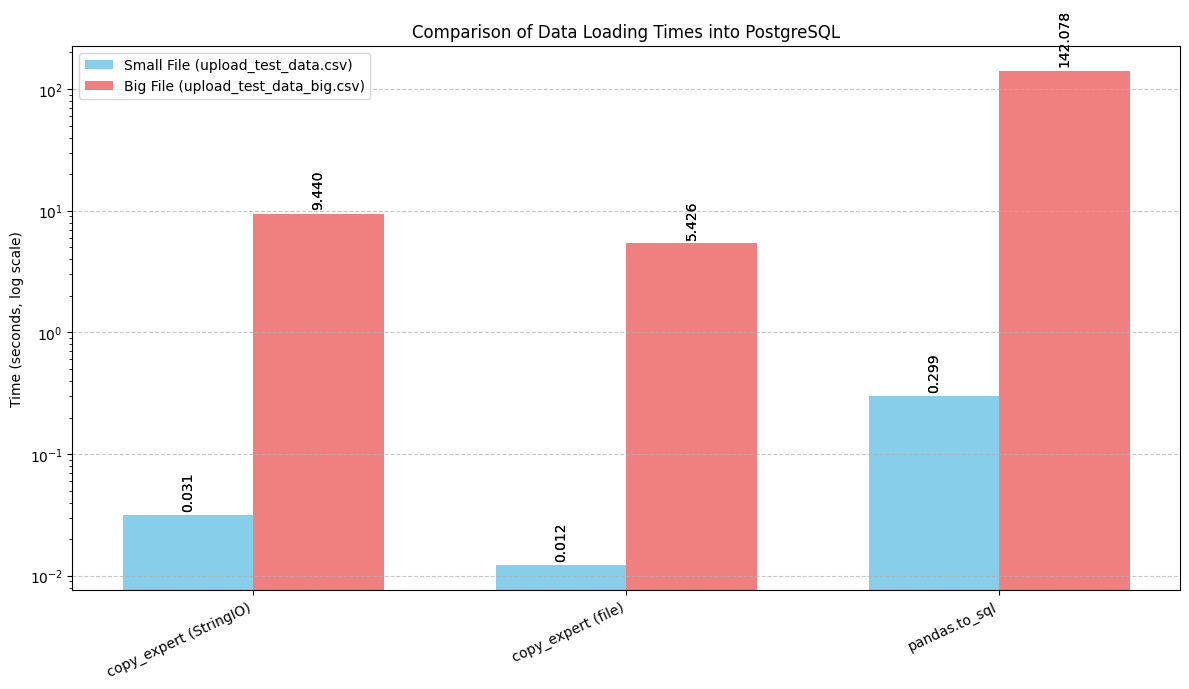

In [ ]:
if not timing_results['small_file'] and not timing_results['big_file']:
    print("No timing results available to plot.")
else:
    # Prepare data for plotting
    methods = list(set(timing_results['small_file'].keys()) | set(timing_results['big_file'].keys()))
    methods.sort() # Ensure consistent order

    small_times = [timing_results['small_file'].get(method, 0) for method in methods] # Use .get with default 0 if method failed
    big_times = [timing_results['big_file'].get(method, 0) for method in methods]

    x = np.arange(len(methods))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 7)) # Increase figure size for better readability

    rects1 = ax.bar(x - width/2, small_times, width, label=f'Small File ({os.path.basename(small_csv_path)})', color='skyblue')
    rects2 = ax.bar(x + width/2, big_times, width, label=f'Big File ({os.path.basename(big_csv_path)})', color='lightcoral')

    # Add some text for labels, title and axes ticks
    ax.set_ylabel('Time (seconds)')
    ax.set_title('Comparison of Data Loading Times into PostgreSQL')
    ax.set_xticks(x)
    # Rotate labels for better fit if names are long
    ax.set_xticklabels(methods, rotation=25, ha="right")
    ax.legend()

    # Add labels on top of bars
    ax.bar_label(rects1, padding=3, fmt='%.3f', rotation=90)
    ax.bar_label(rects2, padding=3, fmt='%.3f', rotation=90)

    # Use a logarithmic scale for the y-axis if the differences are very large
    # This helps visualize smaller values when large values dominate.
    # Check if the max time is significantly larger than the min non-zero time
    all_times = [t for t in small_times + big_times if t > 0]
    if all_times and (max(all_times) / min(all_times) > 50): # Threshold for using log scale
        ax.set_yscale('log')
        ax.set_ylabel('Time (seconds, log scale)')
        # Adjust label formatting for log scale if needed, though default might be fine
        ax.bar_label(rects1, padding=3, fmt='%.3f', rotation=90)
        ax.bar_label(rects2, padding=3, fmt='%.3f', rotation=90)
        print("\nNote: Using logarithmic scale for Y-axis due to large time differences.")


    fig.tight_layout() # Adjust layout to prevent labels overlapping
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add horizontal grid lines
    plt.show()

## Вспомогательные функции

Убедитесь, что эта ячейка выполняется ПЕРЕД запуском кода варианта

In [110]:
# ... (здесь должны быть определения connect_db, close_db, execute_sql, load_df_from_sql и т.д.)
# --- Функция для подключения к БД ---
def connect_db():
    try:
        connection = psycopg2.connect(
            dbname=DB_NAME,
            user=DB_USER,
            password=DB_PASSWORD,
            host=DB_HOST,
            port=DB_PORT
        )
        cursor = connection.cursor()
        print("Успешное подключение к PostgreSQL")
        return connection, cursor
    except Exception as e:
        print(f"Ошибка подключения к PostgreSQL: {e}")
        return None, None

# --- Функция для закрытия соединения ---
def close_db():
    try:
        if cursor:
            cursor.close()
        else:
            print("Курсор уже закрыт или не был инициализирован.")
        
        if connection:
            connection.close()
            print("Соединение с базой данных успешно закрыто.")
        else:
            print("Соединение с базой данных уже закрыто или не было установлено.")
    except Exception as e:
        print(f"Ошибка при закрытии соединения: {e}")

def execute_sql(sql_query, fetch=False):
    """Выполняет SQL-запрос и опционально возвращает результаты."""
    if not connection or not cursor:
        print("Нет подключения к БД.")
        return None
    try:
        # print(f"Выполнение SQL: {sql_query[:100]}...") # Отладка: показать начало запроса
        cursor.execute(sql_query)
        if fetch:
            results = cursor.fetchall()
            # print("Результаты получены.") # Отладка
            return results
        else:
            # Для запросов не SELECT (CREATE, DROP, INSERT, UPDATE, DELETE)
            # connection.commit() # Не требуется при autocommit=True
            # print("Запрос успешно выполнен (без fetch).") # Отладка
            return True # Возвращаем True для индикации успеха выполнения не-SELECT запроса
    except (Exception, Error) as error:
        print(f"Ошибка выполнения SQL: {error}")
        # connection.rollback() # Не требуется при autocommit=True
        return None # Возвращаем None для индикации ошибки

# --- Функция создания таблицы ---
def create_table(table_name):
    print(f"\nПопытка создать таблицу: {table_name}")
    # Шаг 1: Удалить таблицу, если она уже существует
    drop_success = execute_sql(f"DROP TABLE IF EXISTS {table_name};")
    if drop_success is None: # Проверяем, не было ли ошибки при DROP
        print(f"Не удалось выполнить DROP TABLE для {table_name}. Создание таблицы отменено.")
        return # Прерываем создание, если DROP не удался
    
    try:
        cursor.execute(f"""
        CREATE TABLE {table_name} (
            id INTEGER PRIMARY KEY,
            quantity INTEGER,
            cost NUMERIC(10, 2),
            total_revenue NUMERIC(12, 2)
        );
        """)
        connection.commit()
        print(f"Таблица {table_name} успешно создана")
    except Exception as e:
        print(f"Ошибка при создании таблицы {table_name}: {e}")

print("Вспомогательные функции определены.")

# ... (здесь определения load_via_pandas, load_via_copy_file, load_via_copy_stringio и т.д.)

# --- Функции Загрузки Данных ---

def load_via_copy_stringio(df, tbl_name):
    """Загружает данные из DataFrame через StringIO, используя copy_expert."""
    # Проверка подключения и наличия данных
    if not connection or not cursor or df is None:
        print("Нет подключения к БД или DataFrame пуст.")
        return False # Возвращаем False при неудаче
    print(f"Загрузка данных в '{tbl_name}' с использованием copy_expert (StringIO)...")
    start_time = time.time()
    buffer = io.StringIO() # Создаем буфер в памяти
    # Записываем DataFrame в буфер как CSV, включая заголовок
    try:
        df.to_csv(buffer, index=False, header=True, sep=',')
    except Exception as e:
         print(f"Ошибка конвертации DataFrame в CSV: {e}")
         buffer.close() # Закрываем буфер при ошибке
         return False # Возвращаем False при неудаче
    buffer.seek(0) # Перематываем буфер в начало для чтения
    # Формируем SQL команду COPY
    sql_copy = f"COPY {tbl_name} FROM STDIN WITH (FORMAT CSV, HEADER TRUE, DELIMITER ',')"
    try:
        # Выполняем COPY, передавая буфер как файл
        cursor.copy_expert(sql=sql_copy, file=buffer)
        # connection.commit() # Не требуется при autocommit=True
        duration = time.time() - start_time
        print(f"Успешно: Загрузка (StringIO) в '{tbl_name}' завершена за {duration:.2f} сек.")
        return True # Возвращаем True при успехе
    except (Exception, Error) as error:
        print(f"ОШИБКА при выполнении copy_expert (StringIO) для '{tbl_name}': {error}")
        # connection.rollback() # Не требуется при autocommit=True
        return False # Возвращаем False при неудаче
    finally:
        buffer.close() # Гарантируем закрытие буфера в любом случае

def load_via_copy_file(file_path, tbl_name):
    """Загружает данные напрямую из CSV файла, используя copy_expert."""
    # Проверка подключения
    if not connection or not cursor:
       print("Нет подключения к БД.")
       return False # Возвращаем False при неудаче
    # Проверка существования файла
    if not os.path.exists(file_path):
        print(f"ОШИБКА: Файл '{file_path}' не найден.")
        return False # Возвращаем False при неудаче
    print(f"Загрузка данных в '{tbl_name}' с использованием copy_expert (file: {os.path.basename(file_path)})...")
    start_time = time.time()
    # Формируем SQL команду COPY
    sql_copy = f"COPY {tbl_name} FROM STDIN WITH (FORMAT CSV, HEADER TRUE, DELIMITER ',')"
    try:
        # Открываем файл для чтения и передаем его дескриптор в copy_expert
        with open(file_path, 'r', encoding='utf-8') as f:
            cursor.copy_expert(sql=sql_copy, file=f)
        connection.commit() # Не требуется при autocommit=True
        duration = time.time() - start_time
        print(f"Успешно: Загрузка (file) в '{tbl_name}' завершена за {duration:.2f} сек.")
        return True # Возвращаем True при успехе
    except (Exception, Error) as error:
        print(f"ОШИБКА при выполнении copy_expert (file) для '{tbl_name}': {error}")
        # connection.rollback() # Не требуется при autocommit=True
        return False # Возвращаем False при неудаче

# --- Функция загрузки данных из SQL в DataFrame ---
def load_df_from_sql(sql_query):
    """Выполняет SQL-запрос и загружает результаты в Pandas DataFrame."""
    # Проверяем наличие активного подключения
    if not connection: # Для read_sql_query достаточно объекта connection
        print("Нет подключения к БД для загрузки DataFrame.")
        return None # Возвращаем None при ошибке
    print(f"Загрузка данных из SQL в DataFrame: {sql_query[:100]}...") # Показываем начало запроса
    try:
        # Используем pandas.read_sql_query для выполнения запроса и создания DataFrame
        # Эта функция сама управляет курсором и соединением для чтения
        df = pd.read_sql_query(sql_query, connection)
        print(f"Успешно: Загружено {len(df)} строк в DataFrame.")
        return df # Возвращаем созданный DataFrame
    except (Exception, Error) as error:
        # Обрабатываем ошибки при выполнении запроса или создании DataFrame
        print(f"ОШИБКА при загрузке DataFrame из SQL: {error}")
        return None # Возвращаем None при ошибке

print("Вспомогательные функции определены.")

Вспомогательные функции определены.
Вспомогательные функции определены.


# Индивидуальные задания. Вариант 17

Мини-проект: Решение для Варианта 17

In [121]:
# --- Константы для этого варианта ---
small_table_name = 'sales_small'
big_table_name = 'sales_big'
small_csv_path = r'C:\Users\User\Downloads\upload_test_data.csv'
big_csv_path = r'C:\Users\User\Downloads\upload_test_data_big.csv'
# ----------------------------------

connection, cursor = connect_db()
# Проверяем статус подключения перед продолжением
if not connection or not cursor:
    print("Подключение к базе данных неактивно. Пожалуйста, выполните настройку подключения.")
else:
    print("--- Запуск Варианта 17 ---")

    # --- Задача 1: Настройка таблиц ---
print("\n--- Задача 1: Создание таблиц ---")
    
create_table(small_table_name)
create_table(big_table_name)

# --- Задача 2: Загрузка малых данных (copy_expert file) ---
print(f"\n--- Задача 2: Загрузка данных из '{small_csv_path}' в '{small_table_name}' (метод file) ---")
if os.path.exists(small_csv_path):
        # Напрямую вызываем функцию загрузки из файла
        load_via_copy_file(small_csv_path, small_table_name)
        # Функция load_via_copy_file выведет сообщение об успехе/ошибке загрузки
else:
        # Сообщение, если файл не найден
        print(f"ОШИБКА: Файл '{small_csv_path}' не найден. Загрузка не выполнена.")

# --- Задача 3: Загрузка больших данных (copy_expert file) ---
print(f"\n--- Задача 3: Загрузка данных из '{big_csv_path}' в '{big_table_name}' (метод file) ---")
if os.path.exists(big_csv_path):
        # Напрямую вызываем функцию загрузки из файла
        load_via_copy_file(big_csv_path, big_table_name)
        # Функция load_via_copy_file выведет сообщение об успехе/ошибке загрузки
else:
        # Сообщение, если файл не найден
        print(f"ОШИБКА: Файл '{big_csv_path}' не найден. Загрузка не выполнена.")

# --- Задача 4: SQL Анализ ---
print("\n--- Задача 4: SQL Анализ таблицы sales_small ---")
sql_query_task4 = f"""
    SELECT COUNT(*) AS record_count
    FROM {small_table_name}
    WHERE cost = 0.50;
"""
print("Выполнение SQL запроса:")
print(sql_query_task4)
results_task4= execute_sql(sql_query_task4, fetch=True)

if results_task4 is not None:
    if results_task4:
        result_value = results_task4[0][0] 
        print(f"Количество записей: {result_value}")
    else:
        print("Запрос успешно выполнен, но не вернул строк.")
else:
    print("Ошибка выполнения SQL запроса.")

# --- Задача 5: Python Анализ ---
print("\n--- Задача 5: Анализ данных из sales_big с помощью Python ---")
sql_query_task5 = f"SELECT quantity FROM {big_table_name} LIMIT 50000;"
print(f"Получение данных для анализа: {sql_query_task5}")

df_quantity = load_df_from_sql(sql_query_task5)

if df_quantity is not None:
    std_deviation = df_quantity['quantity'].std()
    print(f"Стандартное отклонение quantity: {std_deviation:.2f}")
else:
    print("Ошибка при загрузке данных.")

print("\n--- Вариант 17 Завершен ---")

# print("\n--- Очистка ресурсов ---")
close_db()

Успешное подключение к PostgreSQL
--- Запуск Варианта 17 ---

--- Задача 1: Создание таблиц ---

Попытка создать таблицу: sales_small
Таблица sales_small успешно создана

Попытка создать таблицу: sales_big
Таблица sales_big успешно создана

--- Задача 2: Загрузка данных из 'C:\Users\User\Downloads\upload_test_data.csv' в 'sales_small' (метод file) ---
Загрузка данных в 'sales_small' с использованием copy_expert (file: upload_test_data.csv)...
Успешно: Загрузка (file) в 'sales_small' завершена за 0.01 сек.

--- Задача 3: Загрузка данных из 'C:\Users\User\Downloads\upload_test_data_big.csv' в 'sales_big' (метод file) ---
Загрузка данных в 'sales_big' с использованием copy_expert (file: upload_test_data_big.csv)...
Успешно: Загрузка (file) в 'sales_big' завершена за 3.06 сек.

--- Задача 4: SQL Анализ таблицы sales_small ---
Выполнение SQL запроса:

    SELECT COUNT(*) AS record_count
    FROM sales_small
    WHERE cost = 0.50;

Количество записей: 1

--- Задача 5: Анализ данных из sales_

C:\Users\User\AppData\Local\Temp\ipykernel_2516\538764030.py:157: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, connection)
